# Experiment with MobileNet

Import packages

In [1]:
import os
import cv2
import random

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

2025-06-09 18:08:36.827810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-09 18:08:36.868531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-09 18:08:36.868632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-09 18:08:36.904613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-09 18:08:38.396672: W tensorflow/compiler/tf

Define directories for dataset

In [2]:
train_dir = "../raw_data/classification/train"
val_dir = "../raw_data/classification/valid"
test_dir = "../raw_data/classification/test"

image_size = 224
classes = ["0", "1"]

Load data and resize

In [3]:
def load_and_resize_data(path, classes):
    dataset = []
    for label in classes:
        class_path = os.path.join(path, label)
        label_index = classes.index(label)
        
        for file in os.listdir(class_path):
            file_full_path = os.path.join(class_path, file)
            img = cv2.imread(file_full_path)

            if img is None:
                continue

            img = cv2.resize(img, (image_size, image_size))
            dataset.append([img, label_index])
    
    return dataset

In [4]:
train_dataset = load_and_resize_data(train_dir, classes)
val_dataset = load_and_resize_data(val_dir, classes)
test_dataset = load_and_resize_data(test_dir, classes)

### Data shuffling 

In [5]:
random.shuffle(train_dataset)
random.shuffle(test_dataset)
random.shuffle(val_dataset)

Define X_train, y_train, etc.

In [6]:
def split_img_label(dataset):
    X = []
    y = []
    
    for img, label in train_dataset:
        X.append(img)
        y.append(label)
    
    X = np.array(X)/255
    y = np.array(y)
        
    return X, y

In [7]:
X_train, y_train = split_img_label(train_dataset)
X_val, y_val = split_img_label(val_dataset)
X_test, y_test = split_img_label(test_dataset)

Visualize an image

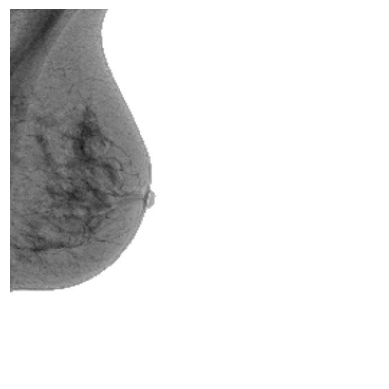

In [8]:
sample_image_path = train_dir + "/0/105_1232990271_png.rf.0d15468a4bec2ad2147f0616b6821681.jpg"
sample_image = Image.open(sample_image_path).resize((350, 350))
plt.imshow(sample_image)
plt.axis('off')  # Turn off the axes for a cleaner visualization
plt.show()

## Setup model: MobileNetV2

In [9]:
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet_v2 import MobileNetV2

def load_model():

    model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=((image_size, image_size, 3)),
    pooling=None
    )

    return model

In [10]:
model = load_model()
model.summary()

2025-06-09 17:21:53.069540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 17:21:53.112527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 17:21:53.112637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 17:21:53.114605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 17:21:53.114720: I external/local_xla/xla/stream_executor

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [11]:
def set_nontrainable_layers(model):

    model.trainable = False

    return model

In [12]:
from keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = load_model()
    base_model = set_nontrainable_layers(base_model)
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(10, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')

    model = tf.keras.Sequential([
      base_model,
      flattening_layer,
      dense_layer,
      prediction_layer
    ])
    return model

In [13]:
add_last_layers(model).summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       627,210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,885,205 (11.01 MB)

 Trainable params: 627,221 (2.39 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
from keras import optimizers

def build_model():
    model = load_model()
    model = add_last_layers(model)
    model.compile(loss="binary_crossentropy", 
                  optimizer = optimizers.Adam(learning_rate=1e-4), 
                  metrics = ["accuracy", "precision", "recall"])

    return model

In [15]:
build_model().summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │       627,210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,885,205 (11.01 MB)

 Trainable params: 627,221 (2.39 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
from keras.callbacks import EarlyStopping

model = build_model()

#Train model:
es = EarlyStopping(patience = 10, restore_best_weights=True)

with tf.device("/GPU:0"):
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=128,
        epochs=200,
        callbacks=[es],
        verbose=1)

Epoch 1/200


I0000 00:00:1749482526.133900  166311 service.cc:145] XLA service 0x7f0ca003ea00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749482526.133975  166311 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-06-09 17:22:06.294008: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-09 17:22:07.089821: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5293 - loss: 1.0625 - precision: 0.2833 - recall: 0.3179 

I0000 00:00:1749482535.951606  166311 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 792ms/step - accuracy: 0.6006 - loss: 0.8350 - precision: 0.3380 - recall: 0.2069 - val_accuracy: 0.6619 - val_loss: 0.6276 - val_precision: 1.0000 - val_recall: 0.0012
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.6513 - loss: 0.6248 - precision: 0.8500 - recall: 0.0020 - val_accuracy: 0.6619 - val_loss: 0.5966 - val_precision: 1.0000 - val_recall: 0.0012
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.6604 - loss: 0.6035 - precision: 0.6000 - recall: 0.0010 - val_accuracy: 0.6619 - val_loss: 0.5663 - val_precision: 1.0000 - val_recall: 0.0012
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.6448 - loss: 0.5874 - precision: 0.5000 - recall: 7.6191e-04 - val_accuracy: 0.6619 - val_loss: 0.5379 - val_precision: 1.0000 - val_recall: 0.0012
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.6698 - loss: 0.5396 - precision: 0.8000 - recall: 0.0018 - val_accuracy: 0.6619 - val_loss: 0.51

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9794 - loss: 0.0922 - precision: 0.9989 - recall: 0.9382 - val_accuracy: 0.9680 - val_loss: 0.0919 - val_precision: 0.9986 - val_recall: 0.9066
Epoch 35/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9714 - loss: 0.0875 - precision: 0.9987 - recall: 0.9138 - val_accuracy: 0.9852 - val_loss: 0.0879 - val_precision: 0.9987 - val_recall: 0.9577
Epoch 36/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9742 - loss: 0.0904 - precision: 0.9984 - recall: 0.9263 - val_accuracy: 0.9945 - val_loss: 0.0896 - val_precision: 0.9987 - val_recall: 0.9851
Epoch 37/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9844 - loss: 0.0900 - precision: 0.9998 - recall: 0.9547 - val_accuracy: 0.9941 - val_loss: 0.0844 - val_precision: 0.9987 - val_recall: 0.9838
Epoch 38/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9893 - loss: 0.0846 - precision: 0.9992 - recall: 0.9689 - val_accuracy: 0.9785 - val_loss: 0.082

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9979 - loss: 0.0572 - precision: 0.9994 - recall: 0.9944 - val_accuracy: 0.9992 - val_loss: 0.0576 - val_precision: 0.9988 - val_recall: 0.9988
Epoch 68/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9953 - loss: 0.0589 - precision: 0.9976 - recall: 0.9885 - val_accuracy: 0.9987 - val_loss: 0.0572 - val_precision: 0.9988 - val_recall: 0.9975
Epoch 69/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9963 - loss: 0.0578 - precision: 0.9987 - recall: 0.9904 - val_accuracy: 0.9992 - val_loss: 0.0570 - val_precision: 0.9988 - val_recall: 0.9988
Epoch 70/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9983 - loss: 0.0581 - precision: 0.9993 - recall: 0.9957 - val_accuracy: 0.9996 - val_loss: 0.0564 - val_precision: 0.9988 - val_recall: 1.0000
Epoch 71/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9993 - loss: 0.0611 - precision: 0.9980 - recall: 1.0000 - val_accuracy: 0.9996 - val_loss: 0.056

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9880 - loss: 0.0415 - precision: 0.9996 - recall: 0.9654 - val_accuracy: 0.9979 - val_loss: 0.0351 - val_precision: 1.0000 - val_recall: 0.9938
Epoch 101/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9978 - loss: 0.0325 - precision: 1.0000 - recall: 0.9936 - val_accuracy: 0.9979 - val_loss: 0.0297 - val_precision: 1.0000 - val_recall: 0.9938
Epoch 102/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9926 - loss: 0.0281 - precision: 1.0000 - recall: 0.9775 - val_accuracy: 1.0000 - val_loss: 0.0267 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 103/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9995 - loss: 0.0254 - precision: 1.0000 - recall: 0.9985 - val_accuracy: 0.9979 - val_loss: 0.0253 - val_precision: 1.0000 - val_recall: 0.9938
Epoch 104/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9980 - loss: 0.0290 - precision: 1.0000 - recall: 0.9942 - val_accuracy: 0.9996 - val_loss: 0

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 0.0168 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0159 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 134/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 0.0150 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0158 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 135/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 0.0186 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0158 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 136/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 0.0139 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0157 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 137/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0161 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 0.0144 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0147 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 167/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0175 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0146 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 168/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 0.0145 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0146 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 169/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 0.0145 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0145 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 170/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 0.0128 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0150 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0140 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 200/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 0.0132 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0139 - val_precision: 1.0000 - val_recall: 1.0000


In [17]:
res = model.evaluate(X_test, y_test)
res

75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 1.0000 - loss: 0.0160 - precision: 1.0000 - recall: 1.0000


[0.013820895925164223, 1.0, 1.0, 1.0]

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

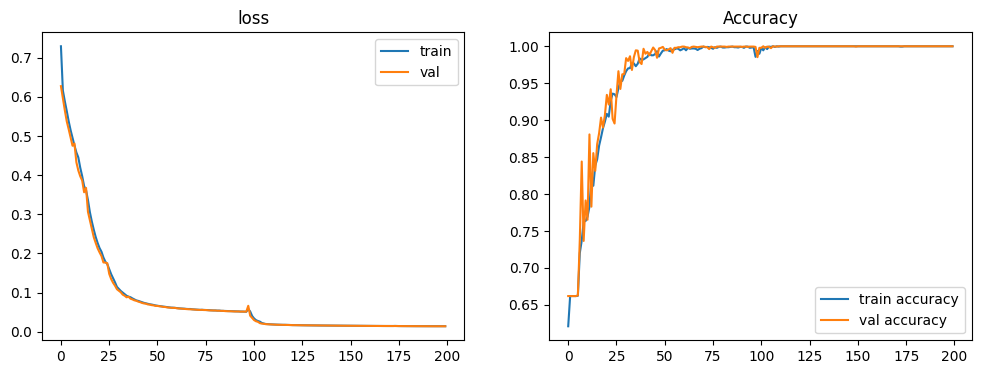

In [19]:
plot_history(history)

## Compare with other dataset

In [20]:
test2_dir = "../raw_data/classification/KAU-BCMD"

In [23]:
test2_dataset = load_and_resize_data(test2_dir, classes)

In [24]:
random.shuffle(test2_dataset)

In [25]:
X_test2, y_test2 = split_img_label(test2_dataset)

In [26]:
res2 = model.evaluate(X_test2, y_test2)
res2

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0160 - precision: 1.0000 - recall: 1.0000


[0.013820895925164223, 1.0, 1.0, 1.0]

In [49]:
model.predict(X_test2[9].reshape(-1,image_size,image_size,3))
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


array([[4.2607022e-05]], dtype=float32)

In [48]:
y_test2[9]

0

In [ ]:
test2_dir = "../raw_data/classification/KAU-BCMD"
test2_dataset = load_and_resize_data(test2_dir, classes)
random.shuffle(test2_dataset)
X_test2, y_test2 = split_img_label(test2_dataset)
res2 = model.evaluate(X_test2, y_test2)
res2

## Other model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Recall
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [10]:
# Initialize a Sequential model
model = Sequential()

# First convolutional layer with 100 filters of size 3x3, using ReLU activation
# The input shape is set to 224x224 pixels with 3 color channels (RGB)
model.add(Conv2D(100, (3, 3), activation="relu", input_shape=(224, 224, 3)))

# First max pooling layer to reduce spatial dimensions (down-sampling by half)
model.add(MaxPooling2D(2, 2))

# Second convolutional layer with 100 filters of size 3x3, using ReLU activation
model.add(Conv2D(100, (3, 3), activation="relu"))

# Second max pooling layer for further down-sampling
model.add(MaxPooling2D(2, 2))

# Third convolutional layer with 64 filters of size 3x3, using ReLU activation
model.add(Conv2D(64, (3, 3), activation="relu"))

# Fourth convolutional layer, also with 64 filters of size 3x3, using ReLU activation
model.add(Conv2D(64, (3, 3), activation="relu"))

# Third max pooling layer to further reduce spatial dimensions
model.add(MaxPooling2D(2, 2))

# Flatten the feature maps into a 1D vector for the fully connected layers
model.add(Flatten())

# First fully connected layer with 64 units and ReLU activation
model.add(Dense(64, activation="relu"))

# Dropout layer to randomly set 20% of the inputs to zero, preventing overfitting
model.add(Dropout(.2))

# Second fully connected layer with 32 units and ReLU activation
model.add(Dense(32, activation="relu"))

# Dropout layer to randomly set 30% of the inputs to zero, for further regularization
model.add(Dropout(.3))

# Third fully connected layer with 32 units and ReLU activation
model.add(Dense(32, activation="relu"))

# Output layer with 1 unit and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary cross-entropy loss for binary classification
# Use accuracy as the evaluation metric
model.compile(optimizer = "adam", loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary for an overview of the layers and parameters
model.summary()

/home/schreiber/.pyenv/versions/3.10.6/envs/lewagon-breast-cancer-project/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-09 18:08:51.862799: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 18:08:52.236810: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 18:08:52.236879: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NU

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 100)  │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 100)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 100)  │        90,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        57,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,560,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,750,725 (10.49 MB)

 Trainable params: 2,750,725 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
es = EarlyStopping(patience = 10, restore_best_weights=True)

with tf.device("/GPU:0"):
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        batch_size=128,
                        epochs=200,
                        callbacks=[es],
                        verbose=1)

Epoch 1/200


I0000 00:00:1749485337.805478  661561 service.cc:145] XLA service 0x7fb014411210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749485337.805551  661561 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-06-09 18:08:57.848222: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-09 18:08:58.161567: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-06-09 18:09:01.454116: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-09 18:09:01.587801: W external/local_tsl/tsl/framework/bfc_allocator.cc:2

 1/19 ━━━━━━━━━━━━━━━━━━━━ 7:21 25s/step - accuracy: 0.3203 - loss: 0.6972

I0000 00:00:1749485359.953144  661561 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5893 - loss: 0.6989 - val_accuracy: 0.6615 - val_loss: 0.6399
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.6467 - loss: 0.6537 - val_accuracy: 0.6615 - val_loss: 0.6521
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.6657 - loss: 0.6478 - val_accuracy: 0.6615 - val_loss: 0.6355
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.6582 - loss: 0.6429 - val_accuracy: 0.6615 - val_loss: 0.6309
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.6691 - loss: 0.6275 - val_accuracy: 0.6615 - val_loss: 0.6108
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.6783 - loss: 0.6173 - val_accuracy: 0.6623 - val_loss: 0.6014
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.6555 - loss: 0.6231 - val_accuracy: 0.6682 - val_loss: 0.6054
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.6718 - loss: 0.6066 - val_accuracy: 0.6918 -

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9816 - loss: 0.0410 - val_accuracy: 0.9941 - val_loss: 0.0136
Epoch 52/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.9707 - loss: 0.0651 - val_accuracy: 0.9945 - val_loss: 0.0129
Epoch 53/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.9746 - loss: 0.0609 - val_accuracy: 0.9941 - val_loss: 0.0132
Epoch 54/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.9736 - loss: 0.0517 - val_accuracy: 0.9958 - val_loss: 0.0106
Epoch 55/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.9749 - loss: 0.0433 - val_accuracy: 0.9945 - val_loss: 0.0136
Epoch 56/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9775 - loss: 0.0477 - val_accuracy: 0.9941 - val_loss: 0.0127
Epoch 57/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.9778 - loss: 0.0487 - val_accuracy: 0.9954 - val_loss: 0.0080
Epoch 58/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9742 - loss: 0.0530 - val_accuracy:

In [12]:
res = model.evaluate(X_test, y_test)
res

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9991 - loss: 0.0019


[0.003328087041154504, 0.9978920817375183]

In [ ]:
test2_dir = "../raw_data/classification/KAU-BCMD"
test2_dataset = load_and_resize_data(test2_dir, classes)
random.shuffle(test2_dataset)
X_test2, y_test2 = split_img_label(test2_dataset)
res2 = model.evaluate(X_test2, y_test2)
res2

In [ ]:
plot_history(history)